In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import time
import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
import lightgbm as lgb
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import gc
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=2)
from tqdm import tqdm_notebook
from tqdm import tqdm
#Plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected=True)


In [5]:
#Here are the types I use. :

#I load objects as categories.
#Binary values are switched to int8
#Binary values with missing values are switched to float16 (int does not understand nan)
##64 bits encoding are all switched to 32, or 16 of possible

In [4]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [5]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = [c for c,v in dtypes.items() if v in numerics]
categorical_columns = [c for c,v in dtypes.items() if v not in numerics]

In [6]:
nrows = 400000
retained_columns = numerical_columns + categorical_columns
train_df = pd.read_csv('train.csv',
                    nrows = nrows,
                    usecols = retained_columns,
                    dtype = dtypes)

In [7]:
retained_columns += ['MachineIdentifier']
retained_columns.remove('HasDetections')
test_df = pd.read_csv('test.csv',
                   usecols = retained_columns,
                   dtype = dtypes)


2.2 Define the type of each variable
In practice, among the numerical variables, many corresponds to identifiers. In the current dataset, the truly numerical variables are in fact rare. Below, I make a list of the variables which are truly numerical, according the the description of the data.

In [9]:
true_numerical_columns = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges'
]

We also list binary variables, since they can be treated as numericals by tree methods:b

In [10]:
binary_variables = [c for c in train_df.columns if train_df[c].nunique() == 2]

to finally make a census of the categorical variables:

In [11]:
categorical_columns = [c for c in train_df.columns 
                       if (c not in true_numerical_columns) & (c not in binary_variables)]

In [12]:
train_df.shape

(400000, 83)

In [13]:
variables = {
    'categorical_columns': len(categorical_columns),
    'binary_variables': len(binary_variables),
    'true_numerical_columns': len(true_numerical_columns)
}
pie_trace = go.Pie(labels=list(variables.keys()), values=list(variables.values()))
layout = dict(title= "Variable types", height=400, width=800)
fig = dict(data=[pie_trace], layout=layout)
iplot(fig)

In [14]:
#Lets first create a data frame with percent of null values and the category with max values in single category
stat = []
for col in train_df.columns:
    stat.append((col,train_df[col].nunique(),train_df[col].isnull().sum()*100/train_df.shape[0],train_df[col].value_counts(normalize=True,dropna=False).values[0]*100,train_df[col].dtype))
stats_df = pd.DataFrame(stat,columns = ['Features','Unique Values','% Null values',"% Values in Single Category",'Data Type'])
stats_df.sort_values('% Null values',ascending=False)

,Features,Unique Values,% Null values,% Values in Single Category,Data Type
28,PuaMode,1,99.97350,99.97350,category
41,Census_ProcessorClass,3,99.57300,99.57300,category
8,DefaultBrowsersIdentifier,477,95.17425,95.17425,float16
68,Census_IsFlightingInternal,2,83.01000,83.01000,float16
52,Census_InternalBatteryType,28,71.02950,71.02950,category
71,Census_ThresholdOptIn,2,63.51075,63.51075,float16
75,Census_IsWIMBootEnabled,1,63.42475,63.42475,float16
31,SmartScreen,12,35.68375,48.30600,category
15,OrganizationIdentifier,43,30.82850,47.11825,float16
29,SMode,2,5.96925,93.98825,float16


In [16]:
#Drop 26 columns with 90%+ values in single category;(These will include columns with 99%+ missing values)

#usefullcols = list(train_df.columns)
#for cols in train_df.columns:
    #percent = train_df[cols].value_counts(normalize=True,dropna=False).values[0]
    #if percent > .9:
        #usefullcols.remove(cols)

In [17]:
#train_df = train_df[usefullcols]

In [18]:
#train_df.shape

1    0.501108
0    0.498893
Name: HasDetections, dtype: float64


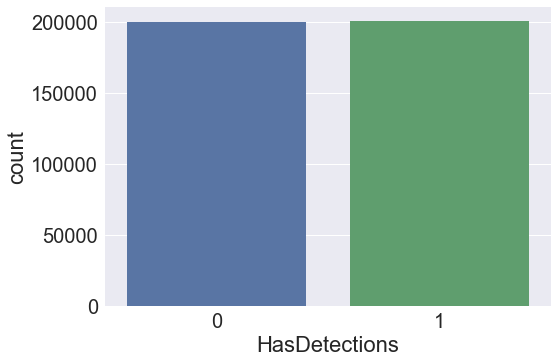

In [15]:
print(train_df["HasDetections"].value_counts(normalize=True,dropna=False))
sns.countplot(x='HasDetections',data=train_df)
plt.show()
#Target coloumn is balanced

Data type category


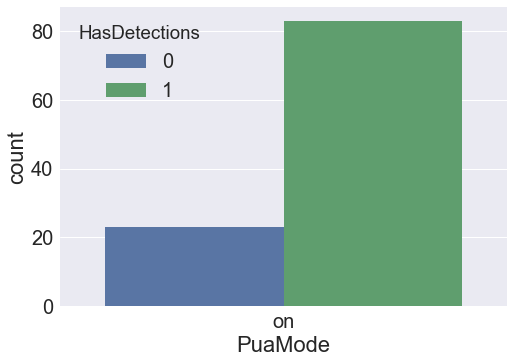

In [16]:
print("Data type",train_df['PuaMode'].dtype)
sns.countplot(x='PuaMode',hue='HasDetections',data=train_df)
plt.show()

In [17]:
#We can remove this feature as large differences are present

In [18]:
## Census_ProcessorClass

Data type category


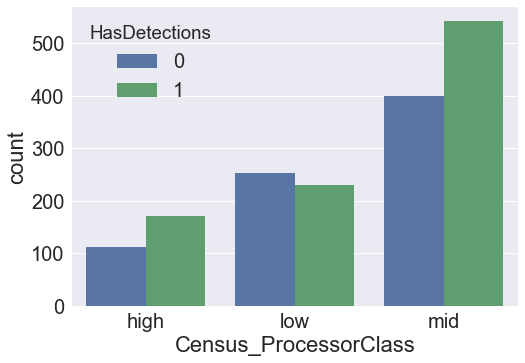

In [19]:
print("Data type",train_df['Census_ProcessorClass'].dtype)
sns.countplot(x='Census_ProcessorClass',hue='HasDetections',data=train_df)
plt.show()

In [20]:
#'Census_ProcessorClass' is 'Number of logical cores in the processor'.
#We can check that the more logical cores, the more probable infection with malwares.
#This feature could be a good features only or component for the combinations with other features. Keep This!!

In [21]:
## DefaultBrowsersIdentifier

In [22]:
#DefaultBrowsersIdentifier means ' ID for the machine's default browser'.

In [23]:
print(train_df['DefaultBrowsersIdentifier'].dtypes)

float16


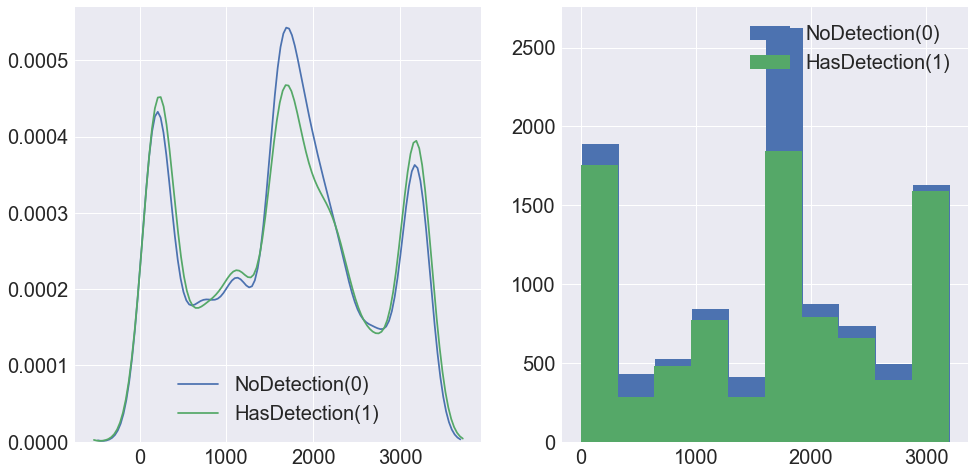

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.kdeplot(train_df.loc[train_df['HasDetections'] == 0, 'DefaultBrowsersIdentifier'], ax=ax[0], label='NoDetection(0)')
sns.kdeplot(train_df.loc[train_df['HasDetections'] == 1, 'DefaultBrowsersIdentifier'], ax=ax[0], label='HasDetection(1)')

train_df.loc[train_df['HasDetections'] == 0, 'DefaultBrowsersIdentifier'].hist(ax=ax[1])
train_df.loc[train_df['HasDetections'] == 1, 'DefaultBrowsersIdentifier'].hist(ax=ax[1])
ax[1].legend(['NoDetection(0)', 'HasDetection(1)'])

plt.show()

In [25]:
## Census_IsFightingInternal

0.0    33089
Name: Census_IsFlightingInternal, dtype: int64
0.0    34870
1.0        1
Name: Census_IsFlightingInternal, dtype: int64


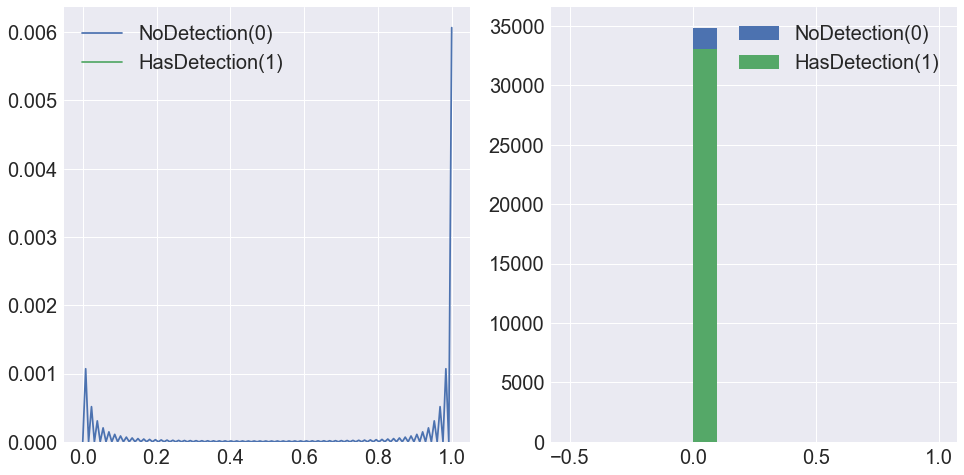

In [26]:
print(train_df.loc[train_df['HasDetections'] == 1, 'Census_IsFlightingInternal'].value_counts())
print(train_df.loc[train_df['HasDetections'] == 0, 'Census_IsFlightingInternal'].value_counts())

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.kdeplot(train_df.loc[train_df['HasDetections'] == 0, 'Census_IsFlightingInternal'], ax=ax[0], label='NoDetection(0)')
sns.kdeplot(train_df.loc[train_df['HasDetections'] == 1, 'Census_IsFlightingInternal'], ax=ax[0], label='HasDetection(1)')

train_df.loc[train_df['HasDetections'] == 0, 'Census_IsFlightingInternal'].hist(ax=ax[1])
train_df.loc[train_df['HasDetections'] == 1, 'Census_IsFlightingInternal'].hist(ax=ax[1])
ax[1].legend(['NoDetection(0)', 'HasDetection(1)'])

plt.show()

Almost all values are 0.0 so remove.

In [27]:
## Census_InternalBatteryType

In [28]:
print(train_df['Census_InternalBatteryType'].dtypes)
train_df['Census_InternalBatteryType'].value_counts()

category


lion    90876
li-i    11026
#        8399
lip      2804
liio     1474
li p      349
li        289
nimh      211
real      120
pbac      107
bq20       90
vbox       60
unkn       18
lgi0       17
lipp       11
lhp0        6
4cel        5
lipo        5
bad         3
ithi        2
ram         2
batt        2
ca48        1
virt        1
lit         1
a140        1
asmb        1
lio        1
Name: Census_InternalBatteryType, dtype: int64

Most batteries are lithum based so lets convert them to two groups

In [29]:
def battery_group(x):
    x = x.lower()
    if 'li' in x:
        return 1
    else:
        return 0
train_df['Census_InternalBatteryType'] = train_df['Census_InternalBatteryType'].apply(battery_group)
print(train_df['Census_InternalBatteryType'].value_counts())

0    293164
1    106836
Name: Census_InternalBatteryType, dtype: int64


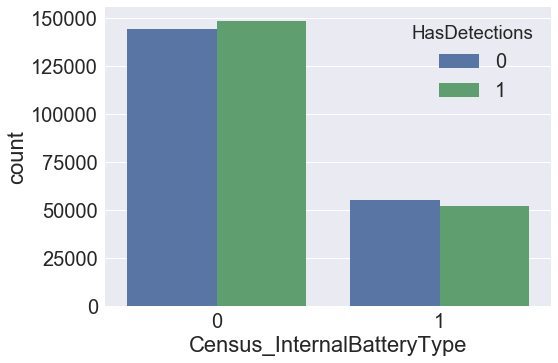

In [30]:
sns.countplot(x='Census_InternalBatteryType', hue='HasDetections',data=train_df)
plt.show()

The difference is really small, i dont think malwares really affects different batteries dofferently. So let's drop

In [31]:
#Now lets drop columns which have 95% more missing values and the above four columns.

In [32]:
#dropped_cols = ['PuaMode','Census_ProcessorClass','DefaultBrowsersIdentifier',
              #  'Census_IsFlightingInternal','Census_InternalBatteryType']

#train_df.drop(dropped_cols,axis=1,inplace=True)
#test_df.drop(dropped_cols,axis=1,inplace=True)

In [33]:
#Create a list of categorical variables in our dataset
Categories_df =  train_df.select_dtypes(include=['category']).columns
print(Categories_df)

Index(['MachineIdentifier', 'ProductName', 'EngineVersion', 'AppVersion',
       'AvSigVersion', 'Platform', 'Processor', 'OsVer',
       'OsPlatformSubRelease', 'OsBuildLab', 'SkuEdition', 'PuaMode',
       'SmartScreen', 'Census_MDC2FormFactor', 'Census_DeviceFamily',
       'Census_ProcessorClass', 'Census_PrimaryDiskTypeName',
       'Census_ChassisTypeName', 'Census_PowerPlatformRoleName',
       'Census_OSVersion', 'Census_OSArchitecture', 'Census_OSBranch',
       'Census_OSEdition', 'Census_OSSkuName', 'Census_OSInstallTypeName',
       'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName',
       'Census_ActivationChannel', 'Census_FlightRing'],
      dtype='object')


In [34]:
## EDA on Categorical variables

In [35]:
#Function for plotting percentage by target

def plotting_category_percent_by_target(cols):
    print(train_df[cols].value_counts().sort_values(ascending=False))
    fig, ax = plt.subplots(1,1, figsize=(10,7.5))
    #fig.patch.set_facecolor('grey')
    category_percent = train_df[[cols,'HasDetections']].groupby(cols,as_index=False).mean()
    category_size = train_df[cols].value_counts().reset_index(drop=False)
    category_size.columns = [cols,'count']
    category_percent = category_percent.merge(category_size, on=cols, how='left')
    category_percent['HasDetections'] = category_percent['HasDetections'].fillna(0)
    category_percent = category_percent.sort_values(by='count', ascending=False)[:20]
    sns.barplot(ax=ax, x='HasDetections', y=cols, data=category_percent, order=category_percent[cols])
    
    for i, p in enumerate(ax.patches):
        ax.annotate('{}'.format(category_percent['count'].values[i]), (p.get_width(), p.get_y()+.2), fontsize=20,color='dimgrey')
   # # invert for largest on top 
    ax.invert_yaxis()
    plt.xlabel('% of HasDetections(target)')
    plt.title(cols,loc='left')
    plt.ylabel(cols)
    plt.show()

win8defender     395683
mse                4313
mseprerelease         3
windowsintune         1
Name: ProductName, dtype: int64


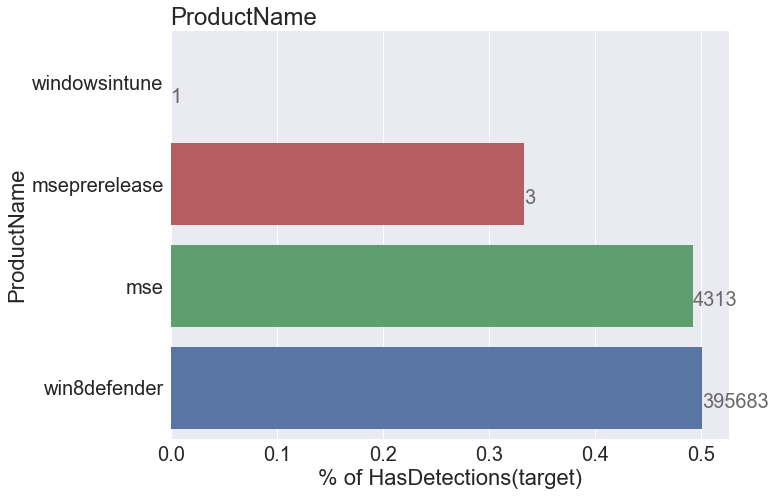

In [36]:
plotting_category_percent_by_target(Categories_df[1])

1.1.15200.1    172762
1.1.15100.1    164699
1.1.15000.2     11716
1.1.14901.4      9661
1.1.14600.4      7076
1.1.14800.3      6116
1.1.15300.6      5447
1.1.14104.0      4193
1.1.13504.0      3144
1.1.15300.5      3115
1.1.14700.5      2075
1.1.14500.5      1991
1.1.14405.2      1653
1.1.14306.0      1076
1.1.14202.0       669
1.1.14003.0       609
1.1.13804.0       427
1.1.13407.0       414
1.1.13303.0       412
1.1.13903.0       409
1.1.13601.0       325
1.1.13704.0       238
1.1.12902.0       231
1.1.13701.0       229
1.1.13202.0       213
1.1.13103.0       210
1.1.14305.0       189
1.1.13000.0       168
1.1.12805.0       110
1.1.15000.1       106
1.1.14901.3        75
1.1.14700.3        73
1.1.14700.4        52
1.1.14800.1        47
1.1.14201.0        13
1.1.14303.0        11
1.1.14500.2         9
1.1.14002.0         6
1.1.11701.0         5
1.1.14103.0         5
1.1.14001.0         4
1.1.12706.0         2
1.1.12400.0         2
1.1.12603.0         2
1.1.14102.0         2
1.1.12002.

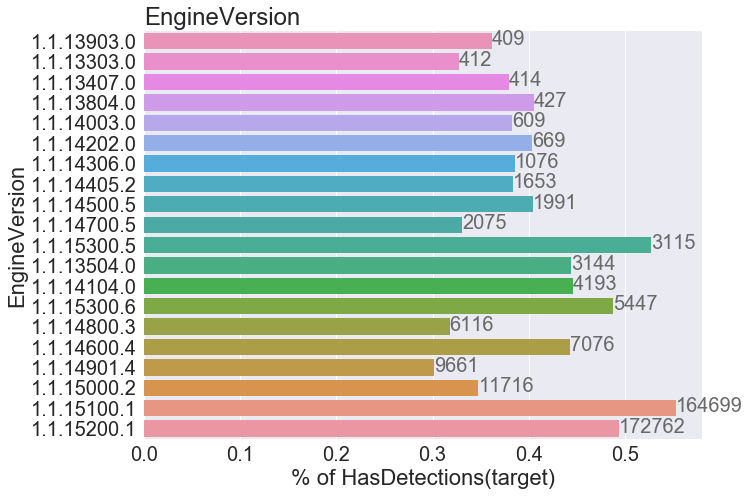

In [37]:
plotting_category_percent_by_target(Categories_df[2])

4.18.1807.18075     230960
4.18.1806.18062      37899
4.12.16299.15        16048
4.10.209.0           12279
4.13.17134.1         11561
4.16.17656.18052     10700
4.13.17134.228       10043
4.9.10586.1106        9290
4.8.10240.17443       9191
4.14.17639.18041      8623
4.12.17007.18022      5230
4.9.10586.0           4965
4.11.15063.447        3986
4.10.14393.0          3435
4.11.15063.0          3091
4.12.17007.18011      2736
4.14.17613.18039      2397
4.8.10240.16384       2040
4.11.15063.1155       2007
4.10.14393.1794       1945
4.9.10586.494         1138
4.10.14393.1198       1050
4.9.10586.672         1014
4.13.17134.191         883
4.10.14393.1613        629
4.18.1809.2            614
4.12.17007.17123       596
4.13.17134.112         590
4.9.10586.589          588
4.9.10586.1045         460
                     ...  
4.8.10240.17354         28
4.4.304.0               24
4.18.1807.20063         22
4.8.10240.17609         21
4.8.10240.17184         20
4.8.10240.17113         20
4

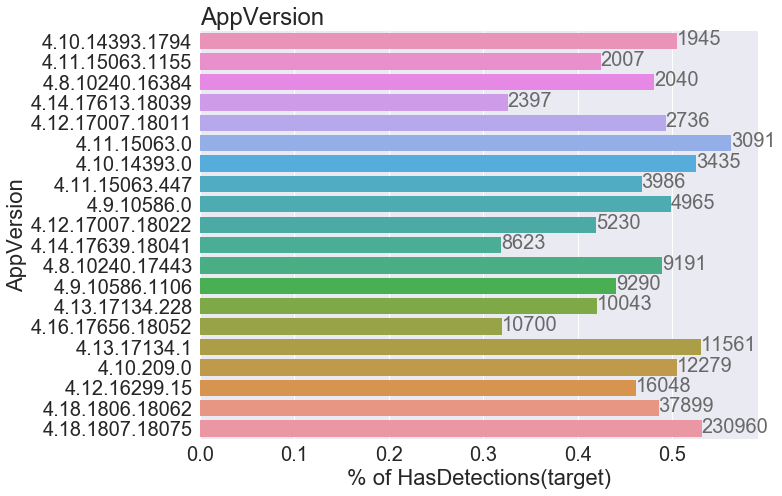

In [38]:
plotting_category_percent_by_target(Categories_df[3])

1.273.1420.0    4614
1.263.48.0      4341
1.275.1140.0    4297
1.275.727.0     4164
1.273.371.0     3861
1.273.1826.0    3837
1.275.1244.0    3450
1.251.42.0      3424
1.275.1209.0    3003
1.273.1749.0    2952
1.273.810.0     2883
1.237.0.0       2847
1.273.1379.0    2232
1.273.1005.0    2142
1.273.894.0     2065
1.273.781.0     1980
1.273.1527.0    1825
1.273.337.0     1793
1.273.461.0     1773
1.273.717.0     1756
1.275.948.0     1684
1.273.1167.0    1679
1.273.950.0     1593
1.275.1293.0    1582
1.273.1034.0    1558
1.273.1112.0    1541
1.275.1487.0    1480
1.275.511.0     1453
1.273.1311.0    1450
1.275.1025.0    1443
                ... 
1.231.300.0        1
1.229.800.0        1
1.227.2284.0       1
1.253.425.0        1
1.247.387.0        1
1.233.1027.0       1
1.241.323.0        1
1.251.590.0        1
1.247.627.0        1
1.235.216.0        1
1.235.2144.0       1
1.239.194.0        1
1.259.480.0        1
1.241.1408.0       1
1.257.854.0        1
1.247.643.0        1
1.241.680.0  

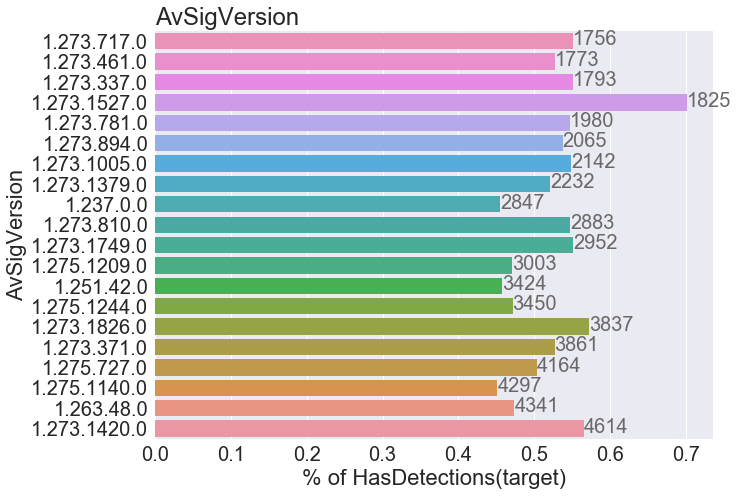

In [39]:
plotting_category_percent_by_target(Categories_df[4])

windows10      386383
windows8         8705
windows7         4272
windows2016       640
Name: Platform, dtype: int64


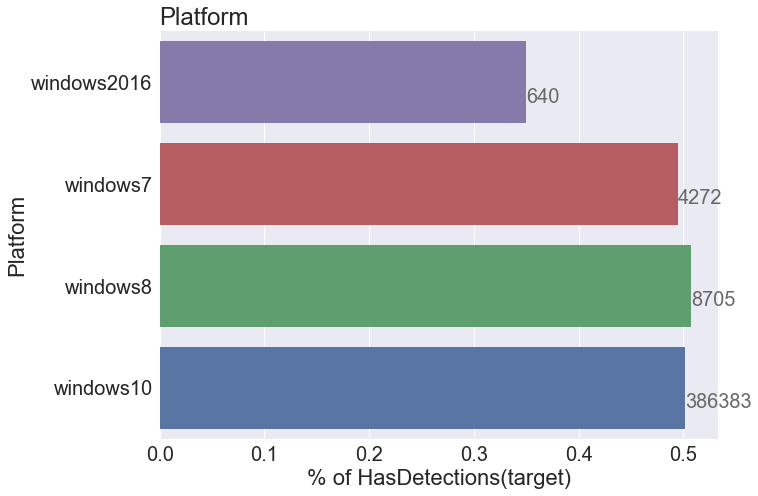

In [40]:
plotting_category_percent_by_target(Categories_df[5])

x64      363507
x86       36473
arm64        20
Name: Processor, dtype: int64


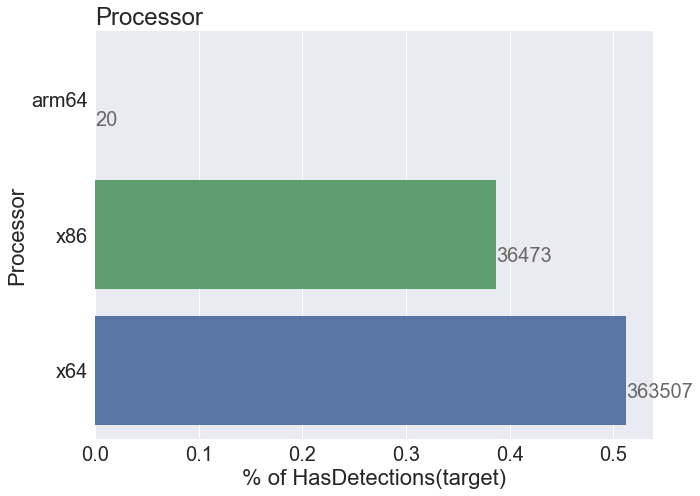

In [41]:
plotting_category_percent_by_target(Categories_df[6])

10.0.0.0      386998
6.3.0.0         8702
6.1.1.0         4246
6.1.0.0           25
10.0.3.0          10
10.0.1.0           7
6.3.1.0            2
10.0.2.0           2
10.0.1.44          1
6.1.3.0            1
10.0.32.72         1
10.0.5.18          1
10.0.0.1           1
10.0.21.0          1
6.3.3.0            1
10.0.4.0           1
Name: OsVer, dtype: int64


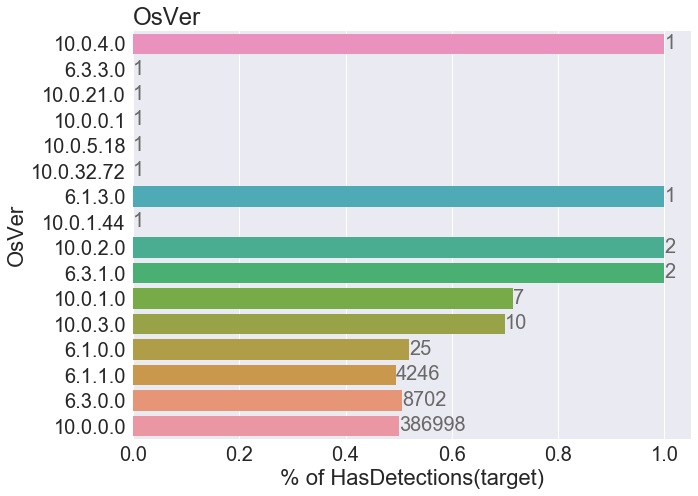

In [42]:
plotting_category_percent_by_target(Categories_df[7])

rs4           175294
rs3           112051
rs2            35306
rs1            32783
th2            18585
th1            12085
windows8.1      8705
windows7        4272
prers5           919
Name: OsPlatformSubRelease, dtype: int64


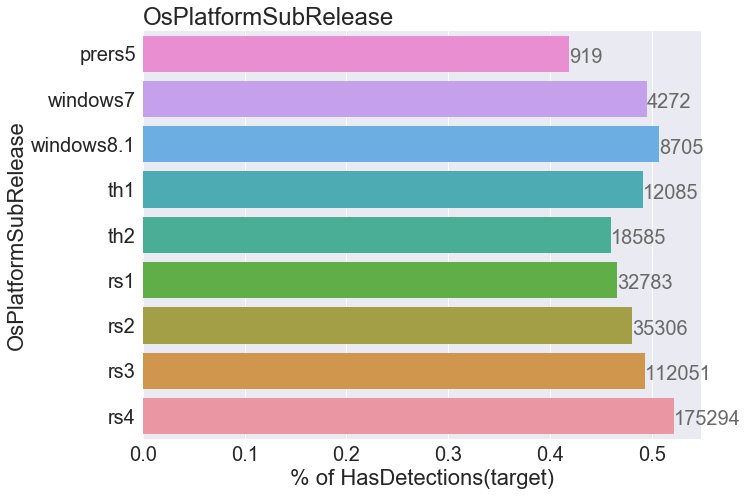

In [43]:
plotting_category_percent_by_target(Categories_df[8])

17134.1.amd64fre.rs4_release.180410-1804                 163675
16299.431.amd64fre.rs3_release_svc_escrow.180502-1908     55795
16299.15.amd64fre.rs3_release.170928-1534                 43302
15063.0.amd64fre.rs2_release.170317-1834                  32467
17134.1.x86fre.rs4_release.180410-1804                    11605
16299.15.x86fre.rs3_release.170928-1534                   10374
14393.2189.amd64fre.rs1_release.180329-1711                8827
10240.17443.amd64fre.th1.170602-2340                       7692
10586.1176.amd64fre.th2_release_sec.170913-1848            6769
15063.0.x86fre.rs2_release.170317-1834                     2839
14393.0.amd64fre.rs1_release.160715-1616                   2610
9600.19101.amd64fre.winblue_ltsb_escrow.180718-1800        2527
9600.19067.amd64fre.winblue_ltsb_escrow.180619-2033        2465
16299.637.amd64fre.rs3_release_svc.180808-1748             2075
14393.2189.x86fre.rs1_release.180329-1711                  1733
10586.1176.x86fre.th2_release_sec.170913

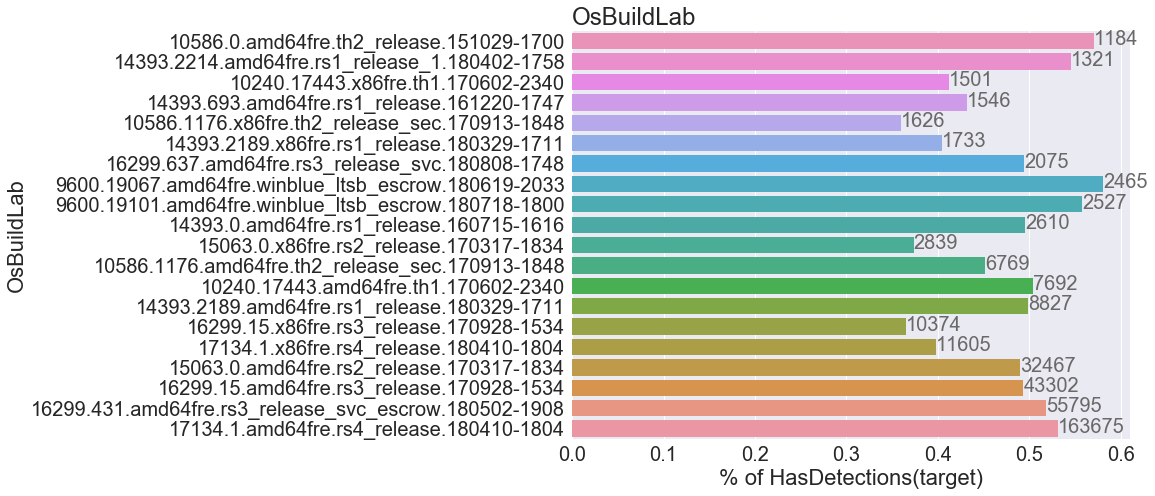

In [44]:
plotting_category_percent_by_target(Categories_df[9])

Home               247335
Pro                144378
Invalid              3594
Education            1763
Enterprise           1587
Enterprise LTSB       953
Cloud                 245
Server                145
Name: SkuEdition, dtype: int64


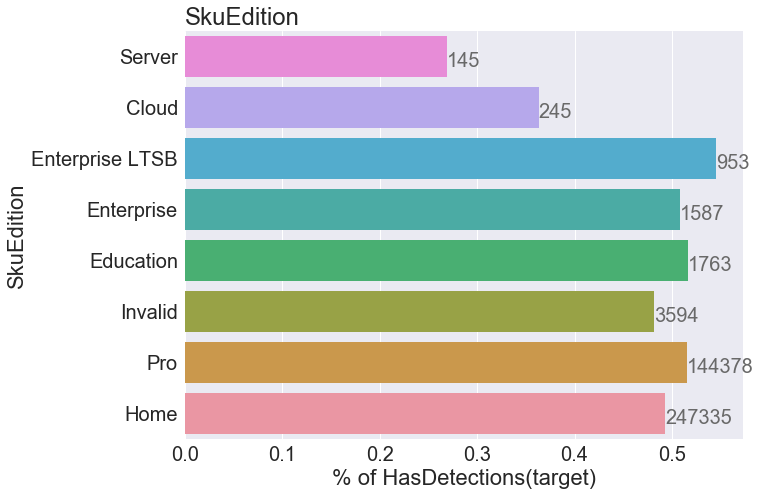

In [45]:
plotting_category_percent_by_target(Categories_df[10])

on    106
Name: PuaMode, dtype: int64


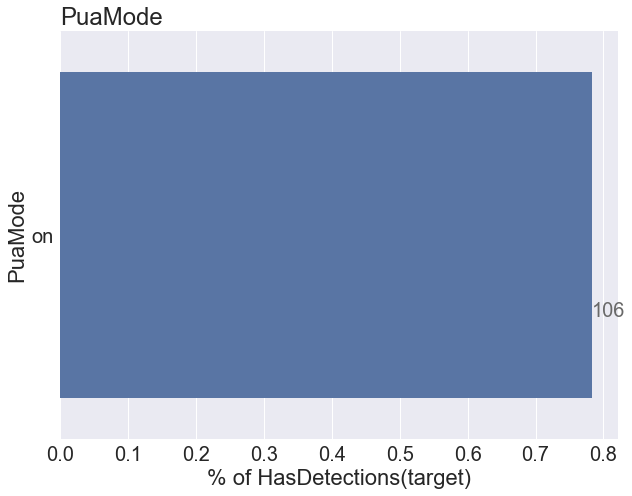

In [46]:
plotting_category_percent_by_target(Categories_df[11])

RequireAdmin    193224
ExistsNotSet     47012
Off               8366
Warn              5987
Prompt            1531
Block             1001
off                 68
On                  30
&#x01;              22
&#x02;              14
on                   9
OFF                  1
Name: SmartScreen, dtype: int64


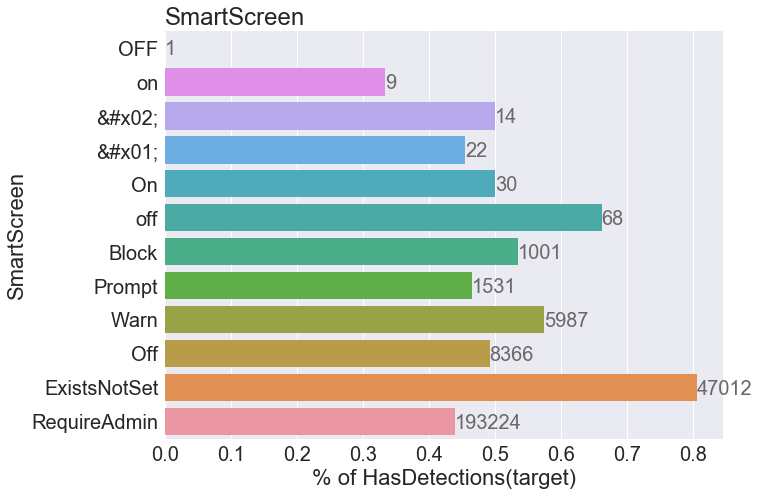

In [47]:
plotting_category_percent_by_target(Categories_df[12])

Notebook        256695
Desktop          87304
Convertible      18241
Detachable       13405
AllInOne         13199
PCOther           6253
LargeTablet       2953
SmallTablet       1368
SmallServer        387
MediumServer       150
LargeServer         43
ServerOther          2
Name: Census_MDC2FormFactor, dtype: int64


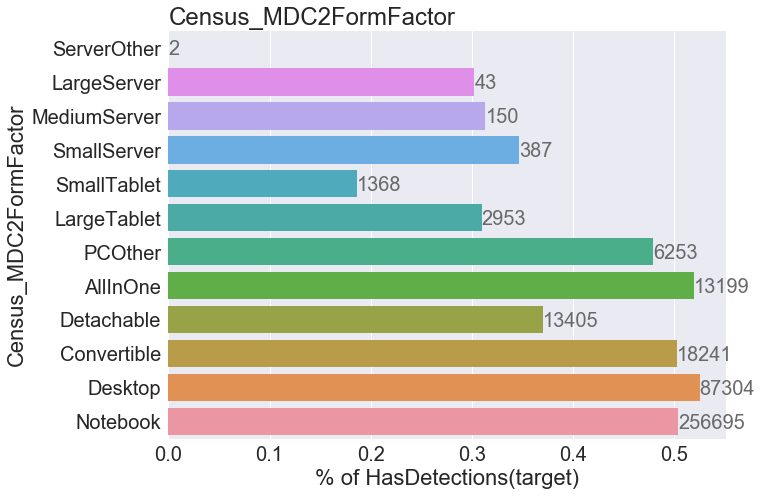

In [48]:
plotting_category_percent_by_target(Categories_df[13])

Windows.Desktop    399360
Windows.Server        640
Name: Census_DeviceFamily, dtype: int64


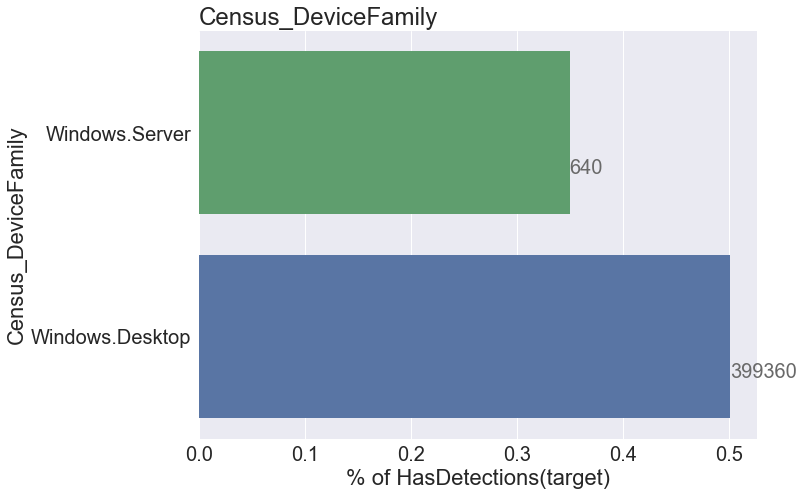

In [49]:
plotting_category_percent_by_target(Categories_df[14])

mid     942
low     483
high    283
Name: Census_ProcessorClass, dtype: int64


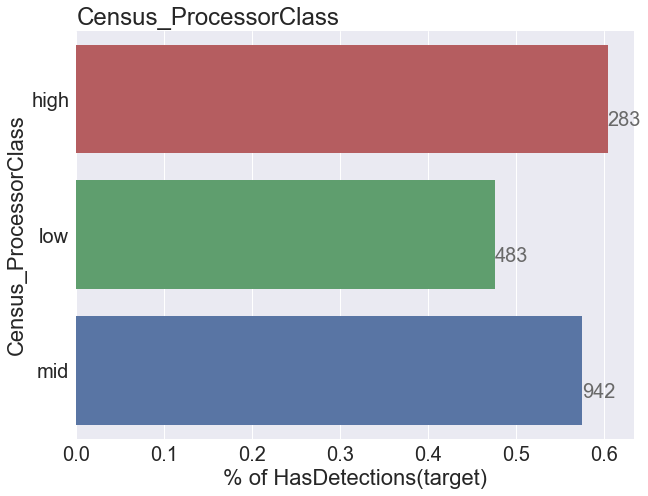

In [50]:
plotting_category_percent_by_target(Categories_df[15])

HDD            260062
SSD            110910
UNKNOWN         15926
Unspecified     12494
Name: Census_PrimaryDiskTypeName, dtype: int64


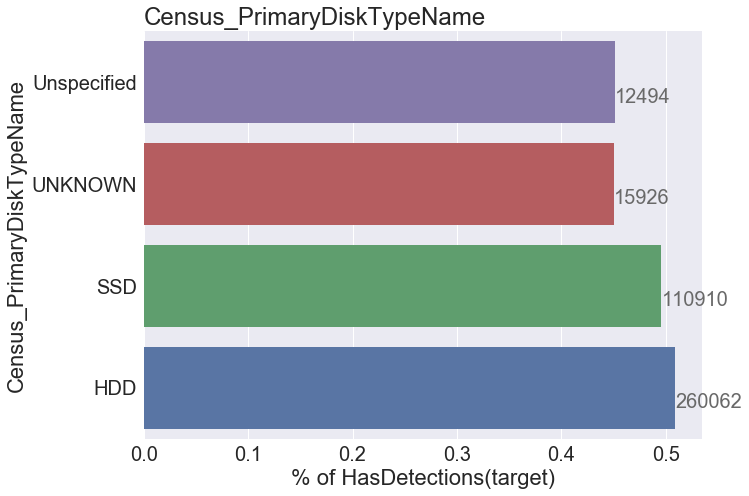

In [51]:
plotting_category_percent_by_target(Categories_df[16])

Notebook               235419
Desktop                 83691
Laptop                  30741
Portable                16329
AllinOne                 9297
MiniTower                3773
Convertible              3756
Other                    3357
UNKNOWN                  3017
Detachable               2327
LowProfileDesktop        2278
HandHeld                 1991
SpaceSaving              1288
Tablet                    618
Tower                     563
Unknown                   451
MainServerChassis         440
MiniPC                    206
LunchBox                  173
RackMountChassis          162
BusExpansionChassis        34
SubNotebook                27
30                         11
0                           6
SealedCasePC                5
StickPC                     5
Blade                       4
MultisystemChassis          4
35                          3
IoTGateway                  1
36                          1
82                          1
32                          1
Name: Cens

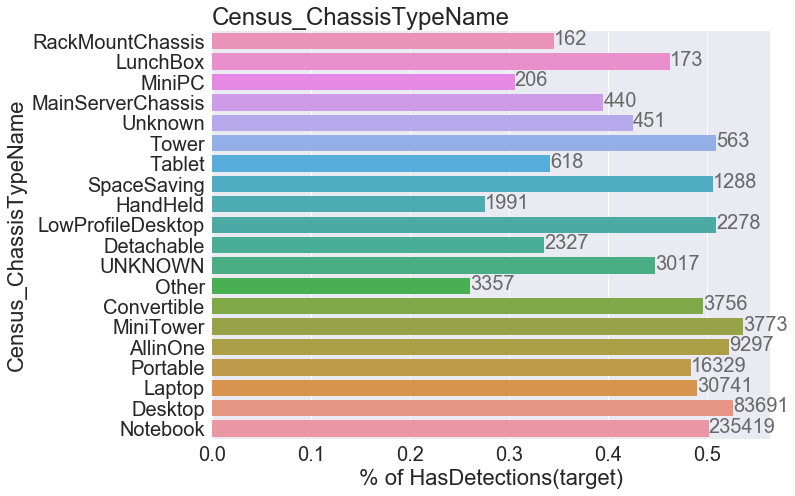

In [52]:
plotting_category_percent_by_target(Categories_df[17])

Mobile               277480
Desktop               92582
Slate                 21939
Workstation            4879
SOHOServer             1719
UNKNOWN                 901
EnterpriseServer        339
AppliancePC             156
PerformanceServer         3
Name: Census_PowerPlatformRoleName, dtype: int64


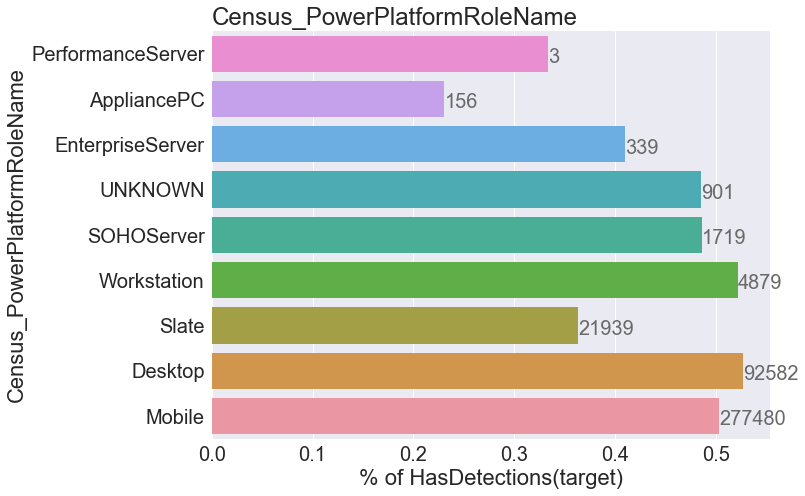

In [53]:
plotting_category_percent_by_target(Categories_df[18])

10.0.17134.228      63225
10.0.17134.165      40474
10.0.16299.431      24312
10.0.17134.285      20802
10.0.16299.547      15558
10.0.17134.112      15523
10.0.16299.371      14564
10.0.17134.191      10281
10.0.14393.2189     10121
10.0.16299.611       9665
10.0.16299.125       9575
10.0.10240.17443     9265
10.0.10586.1176      8253
10.0.16299.492       7458
10.0.16299.309       6876
10.0.17134.286       6139
10.0.16299.15        5267
10.0.17134.254       5013
10.0.15063.1266      4721
10.0.15063.1206      4579
10.0.17134.1         4548
10.0.16299.192       4531
10.0.17134.167       3858
10.0.16299.248       3547
10.0.17134.137       3410
10.0.17134.48        3028
10.0.15063.1088      2944
10.0.15063.0         2921
10.0.14393.0         2706
10.0.17134.81        2531
                    ...  
10.0.17759.1            1
10.0.17754.1000         1
10.0.14393.103          1
10.0.15002.1001         1
10.0.17761.1001         1
10.0.14295.1005         1
10.0.17004.1000         1
10.0.17761.1

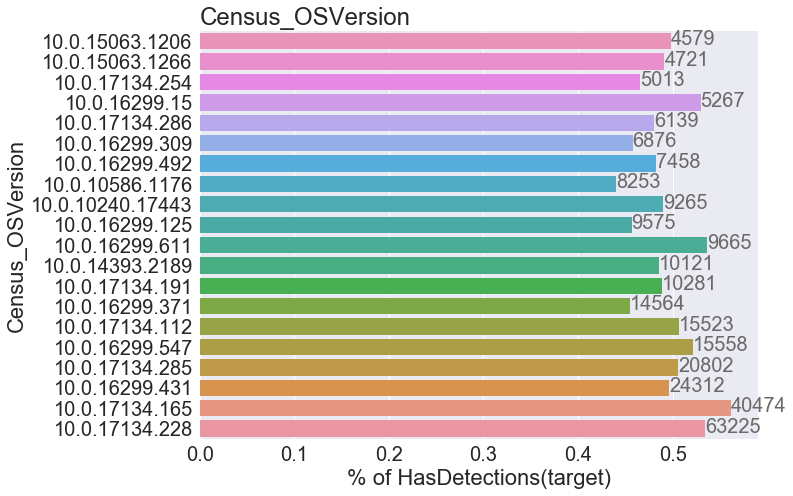

In [54]:
plotting_category_percent_by_target(Categories_df[19])

amd64    363522
x86       36458
arm64        20
Name: Census_OSArchitecture, dtype: int64


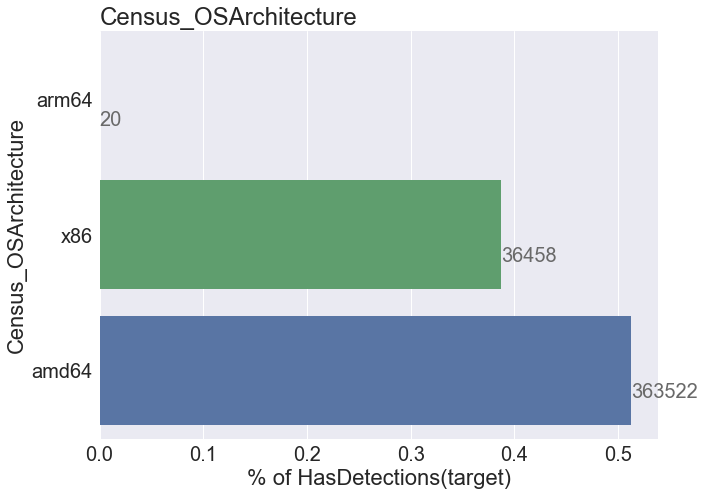

In [55]:
plotting_category_percent_by_target(Categories_df[20])

rs4_release                  179472
rs3_release                   55691
rs3_release_svc_escrow        53407
rs2_release                   36009
rs1_release                   35327
th2_release                   14606
th2_release_sec               12132
th1_st1                        8776
th1                            3374
rs5_release                     681
rs3_release_svc_escrow_im       281
rs_prerelease                   122
rs_prerelease_flt               118
rs5_release_sigma                 3
rs5_release_edge                  1
Name: Census_OSBranch, dtype: int64


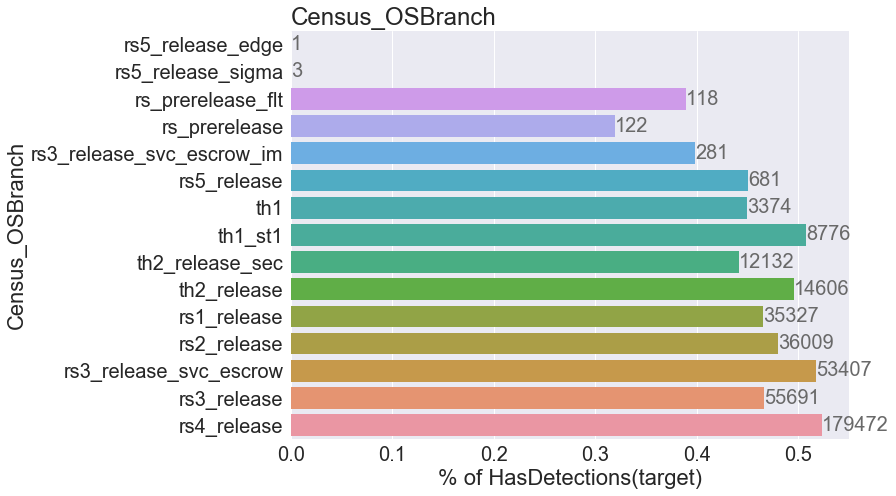

In [56]:
plotting_category_percent_by_target(Categories_df[21])

Core                        155782
Professional                140185
CoreSingleLanguage           87115
CoreCountrySpecific           7505
ProfessionalEducation         2543
Education                     1768
Enterprise                    1630
ProfessionalN                 1292
EnterpriseS                    928
ServerStandard                 465
Cloud                          273
CoreN                          229
ServerStandardEval             109
EducationN                      48
ServerDatacenterEval            36
EnterpriseSN                    32
ServerSolution                  30
EnterpriseN                     18
ProfessionalEducationN           9
ProfessionalWorkstation          2
ProfessionalWorkstationN         1
Name: Census_OSEdition, dtype: int64


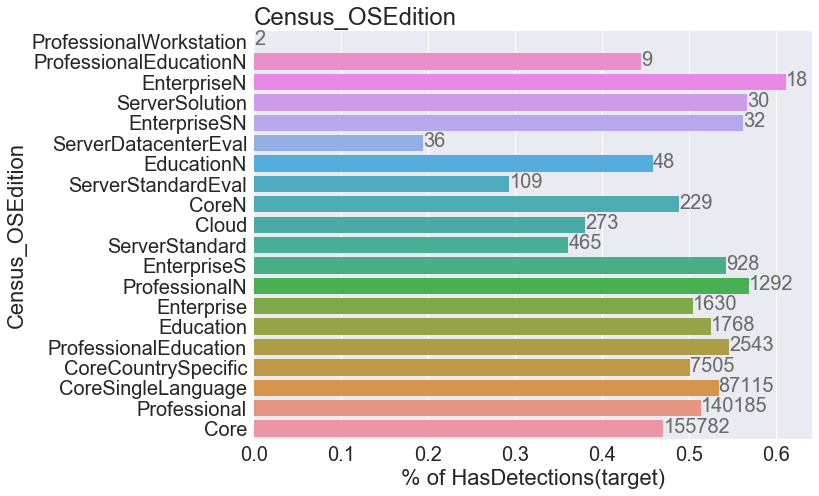

In [57]:
plotting_category_percent_by_target(Categories_df[22])

CORE                            155780
PROFESSIONAL                    142736
CORE_SINGLELANGUAGE              87104
CORE_COUNTRYSPECIFIC              7500
EDUCATION                         1774
ENTERPRISE                        1635
PROFESSIONAL_N                    1299
ENTERPRISE_S                       928
STANDARD_SERVER                    465
CLOUD                              272
CORE_N                             229
STANDARD_EVALUATION_SERVER         109
EDUCATION_N                         48
DATACENTER_EVALUATION_SERVER        36
ENTERPRISE_S_N                      32
SB_SOLUTION_SERVER                  30
ENTERPRISE_N                        19
PRO_WORKSTATION                      2
PRO_WORKSTATION_N                    1
UNLICENSED                           1
Name: Census_OSSkuName, dtype: int64


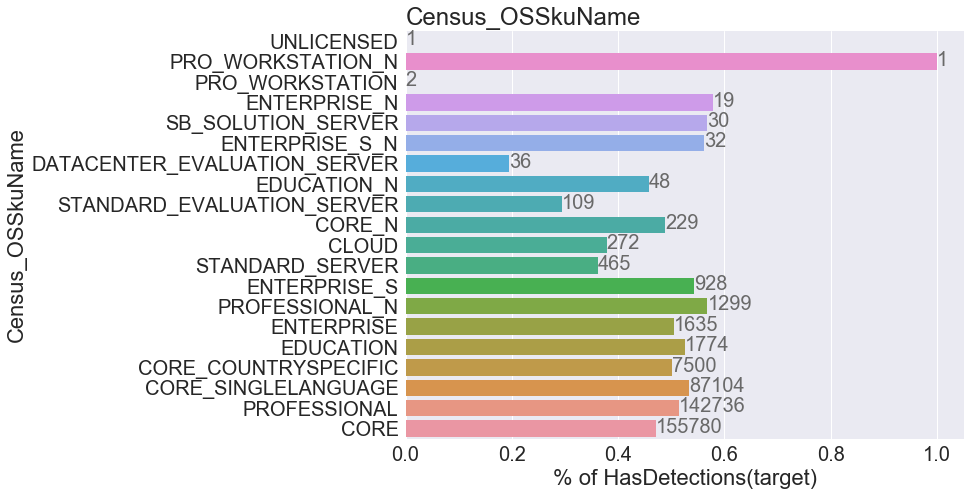

In [58]:
plotting_category_percent_by_target(Categories_df[23])

UUPUpgrade        116664
IBSClean           74043
Update             71371
Upgrade            56040
Other              37906
Reset              29267
Refresh             9264
Clean               3039
CleanPCRefresh      2406
Name: Census_OSInstallTypeName, dtype: int64


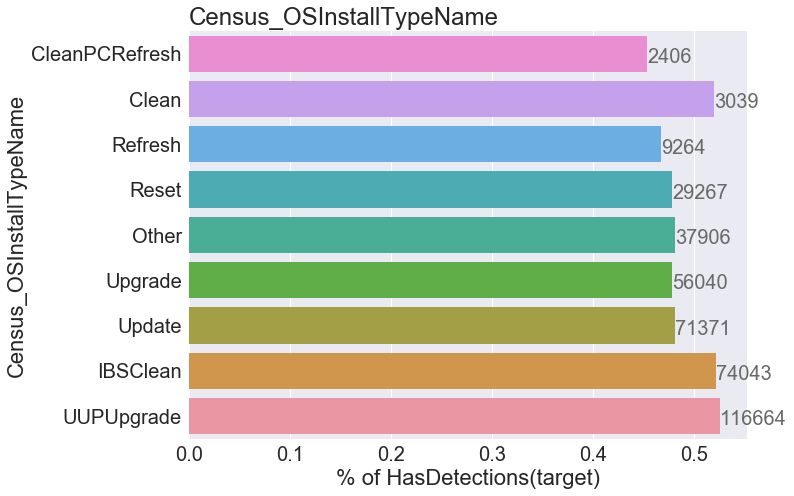

In [59]:
plotting_category_percent_by_target(Categories_df[24])

FullAuto                                 176867
UNKNOWN                                  113340
Notify                                    91387
AutoInstallAndRebootAtMaintenanceTime     16580
Off                                        1186
DownloadNotify                              640
Name: Census_OSWUAutoUpdateOptionsName, dtype: int64


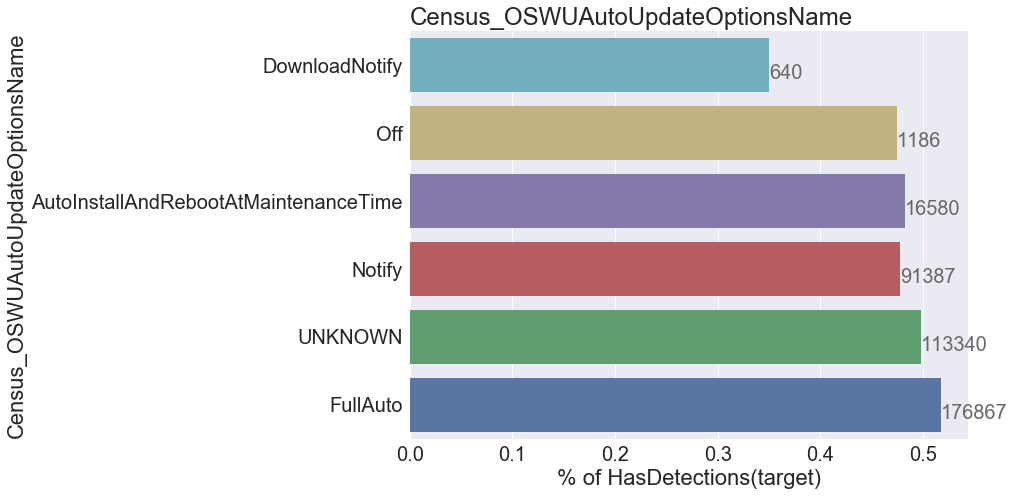

In [60]:
plotting_category_percent_by_target(Categories_df[25])

IS_GENUINE         353143
INVALID_LICENSE     35880
OFFLINE             10350
UNKNOWN               627
Name: Census_GenuineStateName, dtype: int64


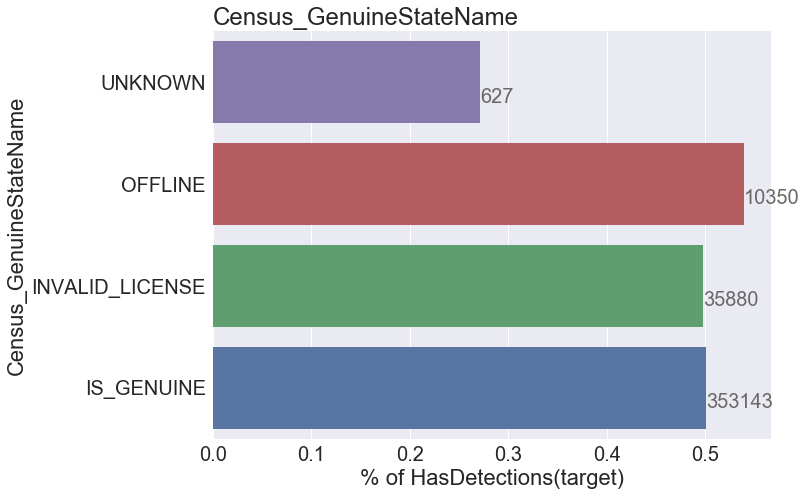

In [61]:
plotting_category_percent_by_target(Categories_df[26])

In [62]:
## Feature Engineering

In [63]:
Cardinality = []
for cols in categorical_columns:
    if cols == 'MachineIdentifier':continue
    Cardinality.append([cols,train_df[cols].nunique()])
Cardinality.sort(key = lambda x:x[1],reverse = False)

trace = go.Bar(y=[x[0] for x in Cardinality],
               x=[x[1] for x in Cardinality],
               orientation='h', marker=dict(color='rgb(49,130,189)'), name='train')

layout = go.Layout(
    title='Categorical cardinality', height=1600, width=800,
    xaxis=dict(
        title='Number of categories',
        titlefont=dict(size=16, color='rgb(107, 107, 107)'),
        domain=[0.25, 1]
    ),
    barmode='group',
    bargap=0.1,
    bargroupgap=0.1
)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

3.1 Frequency encoding¶
For variables with large cardinality, an efficient encoding consists in ranking the categories with respect to their frequencies. These variables are then treated as numerical.

In [64]:
def frequency_encoding(variable):
    t = pd.concat([train_df[variable], test_df[variable]]).value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    return t.to_dict()['level_0']

In [65]:
frequency_encoded_variables = [
    'Census_OEMModelIdentifier',
    'CityIdentifier',
    'Census_FirmwareVersionIdentifier',
    'AvSigVersion',
    'Census_ProcessorModelIdentifier',
    'Census_OEMNameIdentifier',
    'DefaultBrowsersIdentifier'
]

In [66]:
for variable in tqdm(frequency_encoded_variables):
    freq_enc_dict = frequency_encoding(variable)
    train_df[variable] = train_df[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    test_df[variable] = test_df[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    categorical_columns.remove(variable)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:23<00:00,  3.33s/it]


In [67]:
indexer = {}
for col in tqdm(categorical_columns):
    if col == 'MachineIdentifier': continue
    _, indexer[col] = pd.factorize(train_df[col])
    
for col in tqdm(categorical_columns):
    if col == 'MachineIdentifier': continue
    train_df[col] = indexer[col].get_indexer(train_df[col])
    test_df[col] = indexer[col].get_indexer(test_df[col])

100%|████████████████████████████████████████████████████████████████████████████████| 48/48 [1:00:48<00:00, 30.27s/it]


In [68]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Mem. usage decreased to 63.02 Mb (68.4% reduction)
Mem. usage decreased to 1353.54 Mb (66.5% reduction)


In [73]:
train_df[:5]

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,0,0,0,974.0,0,0,0,NaN,0,...,2624.0,0,-1,0.0,0,0,0.0,0.0,0,0
1,000007535c3f730efa9ea0b7ef1bd645,0,1,1,0.0,0,0,0,NaN,0,...,1149.0,0,-1,0.0,0,0,0.0,0.0,1,0
2,000007905a28d863f6d0d597892cd692,0,0,0,1233.0,0,0,0,NaN,0,...,175.0,0,-1,0.0,0,0,0.0,0.0,2,0
3,00000b11598a75ea8ba1beea8459149f,0,0,0,762.0,0,0,0,NaN,0,...,30.0,0,-1,0.0,0,0,0.0,0.0,2,1
4,000014a5f00daa18e76b81417eeb99fc,0,0,0,566.0,0,0,0,NaN,0,...,134.0,0,0,0.0,0,0,0.0,0.0,3,1


In [69]:
target = train_df['HasDetections']
del train_df['HasDetections']

## Training the model

In [70]:
param = {'num_leaves': 60,
         'min_data_in_leaf': 60, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.1,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 133,
         "verbosity": -1}

In [71]:
#Number of iteration over each fold
max_iter = 5

In [72]:
gc.collect()

8567

In [79]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train_df))
categorical_columns = [c for c in categorical_columns if c not in ['MachineIdentifier']]
features = [c for c in train_df.columns if c not in ['MachineIdentifier']]
predictions = np.zeros(len(test_df))
start = time.time()
feature_importance_df = pd.DataFrame()
start_time= time.time()
score = [0 for _ in range(folds.n_splits)]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature = categorical_columns
                          )
    val_data = lgb.Dataset(train_df.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature = categorical_columns
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # we perform predictions by chunks
    initial_idx = 0
    chunk_size = 1000000
    current_pred = np.zeros(len(test_df))
    while initial_idx < test_df.shape[0]:
        final_idx = min(initial_idx + chunk_size, test_df.shape[0])
        idx = range(initial_idx, final_idx)
        current_pred[idx] = clf.predict(test_df.iloc[idx][features], num_iteration=clf.best_iteration)
        initial_idx = final_idx
    predictions += current_pred / min(folds.n_splits, max_iter)
   
    print("time elapsed: {:<5.2}s".format((time.time() - start_time) / 3600))
    score[fold_] = roc_auc_score(target.iloc[val_idx], oof[val_idx])
    if fold_ == max_iter - 1: break
        
if (folds.n_splits == max_iter):
    print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))
else:
     print("CV score: {:<8.5f}".format(sum(score) / max_iter))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.768187	valid_1's auc: 0.716412
[200]	training's auc: 0.79522	valid_1's auc: 0.716123
[300]	training's auc: 0.813294	valid_1's auc: 0.71434
Early stopping, best iteration is:
[123]	training's auc: 0.775678	valid_1's auc: 0.716796
time elapsed: 0.064s
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.768791	valid_1's auc: 0.715016
[200]	training's auc: 0.795093	valid_1's auc: 0.713907
Early stopping, best iteration is:
[99]	training's auc: 0.768481	valid_1's auc: 0.715044
time elapsed: 0.12 s
fold n°2
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.769429	valid_1's auc: 0.714852
[200]	training's auc: 0.796041	valid_1's auc: 0.713952
Early stopping, best iteration is:
[94]	training's auc: 0.767126	valid_1's auc: 0.714924
time elapsed: 0.18 s
fold n°3
Training until validation scores don't improve for 200 rounds

### Feature_Importance

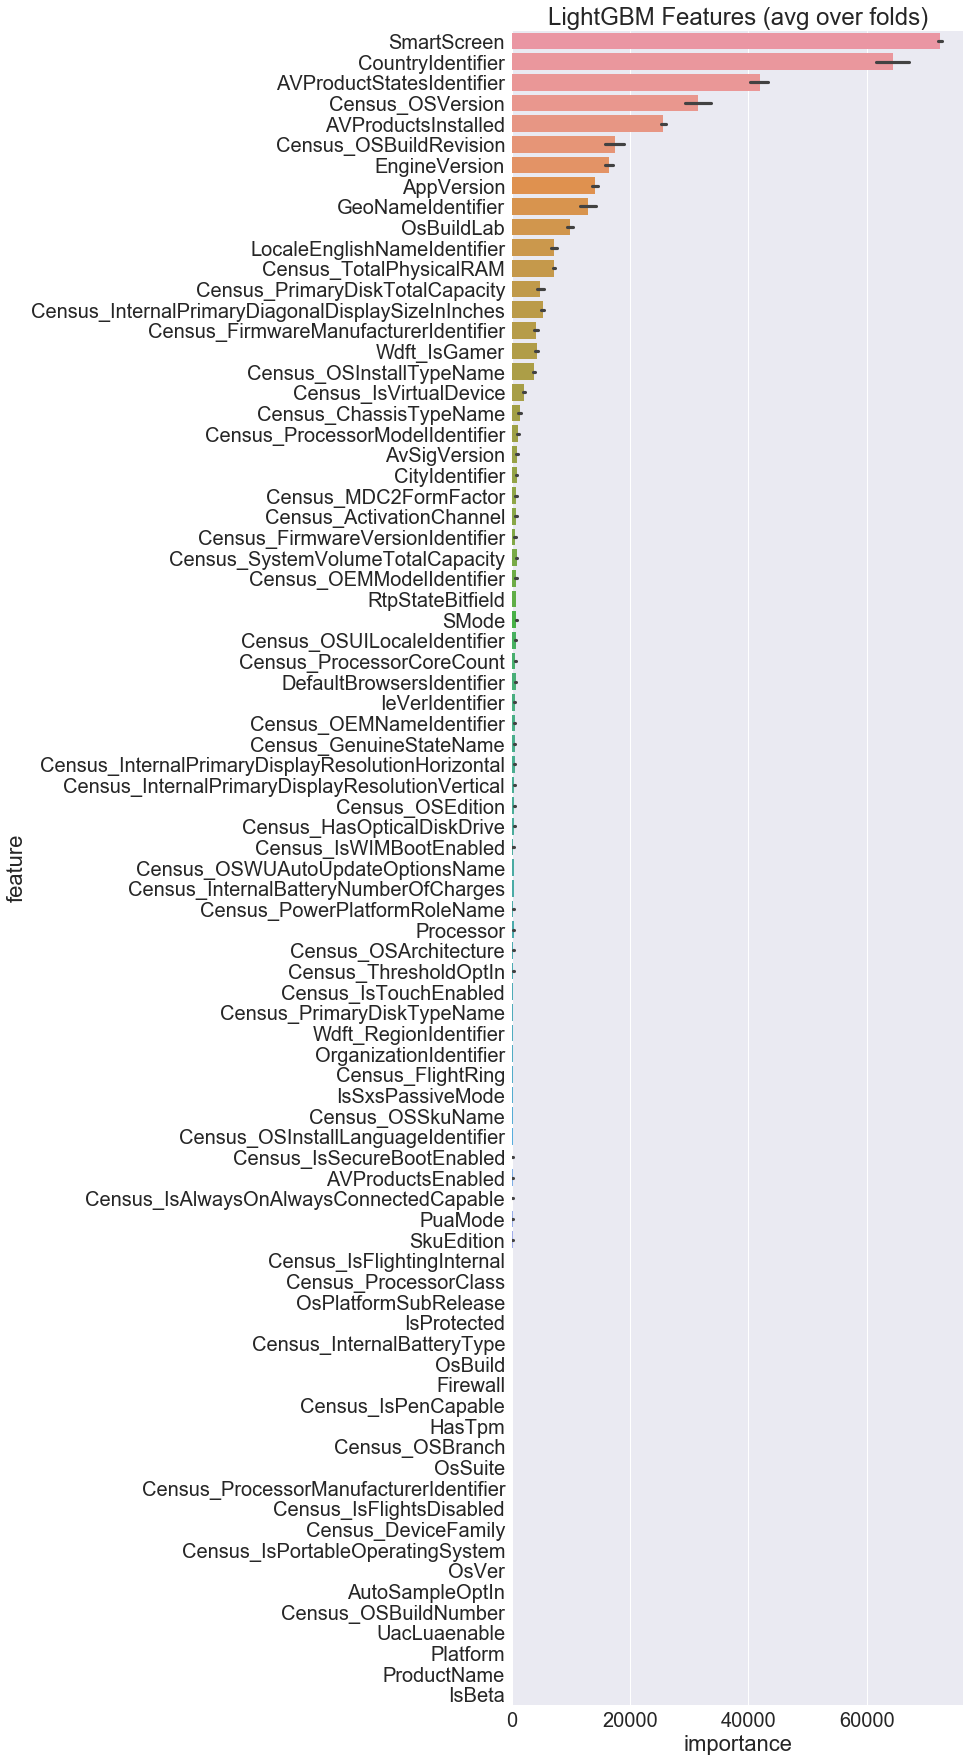

In [80]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [82]:
sub_df = pd.DataFrame({"MachineIdentifier": test_df["MachineIdentifier"].values})
sub_df["HasDetections"] = predictions
sub_df[:10]

,MachineIdentifier,HasDetections
0,0000010489e3af074adeac69c53e555e,0.546993
1,00000176ac758d54827acd545b6315a5,0.508874
2,0000019dcefc128c2d4387c1273dae1d,0.423972
3,0000055553dc51b1295785415f1a224d,0.307121
4,00000574cefffeca83ec8adf9285b2bf,0.377666
5,000007ffedd31948f08e6c16da31f6d1,0.480954
6,000008f31610018d898e5f315cdf1bd1,0.257251
7,00000a3c447250626dbcc628c9cbc460,0.432763
8,00000b6bf217ec9aef0f68d5c6705897,0.442452
9,00000b8d3776b13e93ad83676a28e4aa,0.286671


In [83]:
sub_df.to_csv("submit01.csv", index=False)

In [86]:
train_df.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,0000028988387b115f69f31a3bf04f09,0,0,0,974.0,0,0,0,NaN,0,...,0,2624.0,0,-1,0.0,0,0,0.0,0.0,0
1,000007535c3f730efa9ea0b7ef1bd645,0,1,1,0.0,0,0,0,NaN,0,...,0,1149.0,0,-1,0.0,0,0,0.0,0.0,1
2,000007905a28d863f6d0d597892cd692,0,0,0,1233.0,0,0,0,NaN,0,...,1,175.0,0,-1,0.0,0,0,0.0,0.0,2
3,00000b11598a75ea8ba1beea8459149f,0,0,0,762.0,0,0,0,NaN,0,...,2,30.0,0,-1,0.0,0,0,0.0,0.0,2
4,000014a5f00daa18e76b81417eeb99fc,0,0,0,566.0,0,0,0,NaN,0,...,2,134.0,0,0,0.0,0,0,0.0,0.0,3
